# ML Classification - Network Traffic Analysis
## Part 2 - DATA PROCESSING

In this notebook, we load the cleaned dataset file and process it into an acceptable format to ML algorithms.

> **INPUT:** the cleaned dataset csv file as resulted from the previous cleaning phase.<br>
> **OUTPUT:** a processed (final version) of the dataset as a csv file.  

***

### 1. INITIALIZATION

In [69]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
import ipaddress
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [70]:
# Set display options
pd.set_option('display.max_columns', None)

### 2. LOADING CLEANED DATASET

#### Reading dataset file into pandas DataFrame

In [71]:
# Initialize required variables to read the cleaned data file
data_file_location = "..\\data\\interim\\"
data_file_name = "conn.log.labeled_cleaned"
data_file_ext = ".csv"

# Read the dataset
data_df = pd.read_csv(data_file_location + data_file_name + data_file_ext, index_col=0)

#### Exploring dataset summary and statistics

In [72]:
# Check dataset shape
data_df.shape

(23145, 15)

In [73]:
# Check dataset head
data_df.head()

,id.orig_p,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,41040,80,tcp,NaN,3.139211,0.0,0.0,S0,0,S,3,180,0,0,Benign
1,41040,80,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,Benign
2,41040,80,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,Benign
3,41040,80,tcp,http,1.477656,149.0,128252.0,SF,2896,ShADadttcfF,94,5525,96,139044,Benign
4,41042,80,tcp,NaN,3.147116,0.0,0.0,S0,0,S,3,180,0,0,Benign


In [74]:
# Check dataset summary
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23145 entries, 0 to 23144
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id.orig_p      23145 non-null  int64  
 1   id.resp_p      23145 non-null  int64  
 2   proto          23145 non-null  object 
 3   service        1847 non-null   object 
 4   duration       5321 non-null   float64
 5   orig_bytes     5321 non-null   float64
 6   resp_bytes     5321 non-null   float64
 7   conn_state     23145 non-null  object 
 8   missed_bytes   23145 non-null  int64  
 9   history        23145 non-null  object 
 10  orig_pkts      23145 non-null  int64  
 11  orig_ip_bytes  23145 non-null  int64  
 12  resp_pkts      23145 non-null  int64  
 13  resp_ip_bytes  23145 non-null  int64  
 14  label          23145 non-null  object 
dtypes: float64(3), int64(7), object(5)
memory usage: 2.8+ MB


### 3. DATA PREPROCESSING

#### Analyzing target attribute

In [75]:
# Check null values in the target attribute
data_df["label"].isna().sum()

0

In [76]:
# Check values distribution
data_df["label"].value_counts()

Malicious    21222
Benign        1923
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

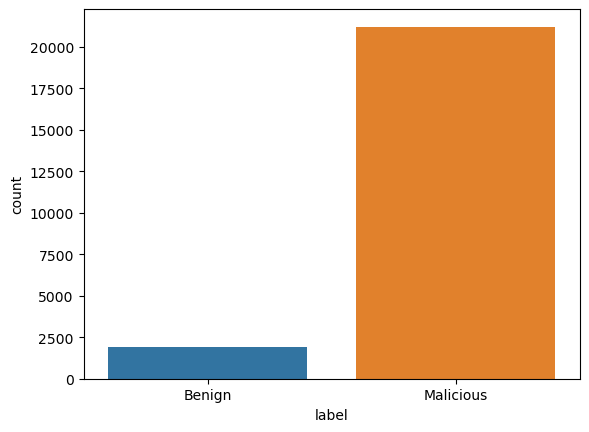

In [77]:
# Plot target attribute on a count plot
sns.countplot(data=data_df, x="label")

- As we can see from these statistics, the target attribute is highly imbalanced.
- We will maintain the original distribution for now until we explore the models' performance. 
- Suitable techniques will be applied to re-balance the labels if we couldn't achieve an acceptable prediction accuracy. 

#### Encoding target attribute

In [78]:
# Initialize encoder with default parameters
target_le = LabelEncoder()

# Fit the encoder to the target attribute
encoded_attribute = target_le.fit_transform(data_df["label"])

# Replace target attribute with encoded values
data_df["label"] = encoded_attribute

# Check mapped labels
dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))

{'Benign': 0, 'Malicious': 1}

#### Handling outliers

In [79]:
# Use describe() method to obtain general statistics about the numerical features
numerical_features = ["duration", "orig_bytes",	"resp_bytes", "missed_bytes", "orig_pkts",	"orig_ip_bytes", "resp_pkts", "resp_ip_bytes"]
data_df[numerical_features].describe()

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,5321.000000,5.321000e+03,5321.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000
mean,22.806503,1.478868e+04,350.429431,2.127112,6.375157,3.664312e+03,0.611017,111.218967
std,722.522302,1.036441e+06,5378.262771,102.490787,178.548725,5.003762e+05,8.305898,2713.082822
min,0.000497,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,2.075814,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,3.110974,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,3.153695,6.200000e+01,243.000000,0.000000,1.000000,7.600000e+01,0.000000,0.000000
max,48976.819063,7.554662e+07,164266.000000,5792.000000,18444.000000,7.606306e+07,1070.000000,168910.000000


- In a quick reading of the statistical summary, we noticed many features with values that can be seen as outliers. 
- It's fairly difficult to confirm such values and their actual reasons without proper explanations by experts in the corresponding domain.
- For the sake of this demo, we will treat only "duration" as a feature with actual outliers as it's the only feature with a significant amount of unique values.

<Axes: ylabel='duration'>

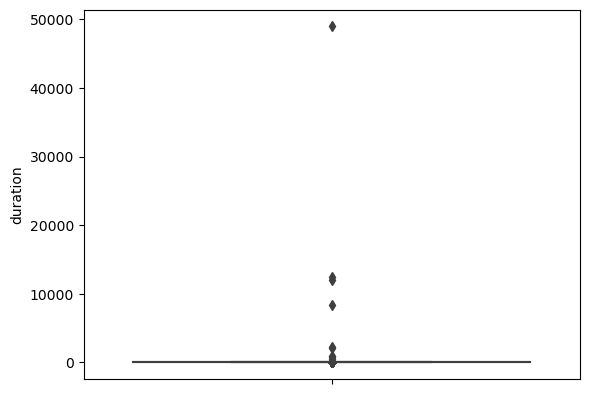

In [80]:
# Plot "duration" feature on a boxplot
sns.boxplot(data=data_df, y="duration")

In [81]:
# Replace outliers using IQR (Inter-quartile Range)
outliers_columns = ['duration']
for col_name in outliers_columns:
    # Calculate first and third quartiles
    q1, q3 = np.nanpercentile(data_df[col_name],[25,75])
    
    # Calculate the inter-quartile range
    intr_qr = q3-q1

    # Calculate lower and higher bounds
    iqr_min_val = q1-(1.5*intr_qr)
    iqr_max_val = q3+(1.5*intr_qr)
    print(f"(min,max) bounds for \"{col_name}\": ({iqr_min_val},{iqr_max_val})")
    
    # Replace values that are less than min or larger then max with np.nan
    data_df.loc[data_df[col_name] < iqr_min_val, col_name] = np.nan
    data_df.loc[data_df[col_name] > iqr_max_val, col_name] = np.nan

(min,max) bounds for "duration": (0.4589924999999997,4.7705165)


In [82]:
# Reevaluate the new distribution of values
data_df["duration"].describe()

count    3718.000000
mean        2.848130
std         0.806614
min         0.553685
25%         3.085004
50%         3.110717
75%         3.140398
max         4.723553
Name: duration, dtype: float64

#### Handling missing values

In [83]:
# Check the number of null values in each column
data_df.isnull().sum().sort_values(ascending=False)

service          21298
duration         19427
orig_bytes       17824
resp_bytes       17824
id.orig_p            0
id.resp_p            0
proto                0
conn_state           0
missed_bytes         0
history              0
orig_pkts            0
orig_ip_bytes        0
resp_pkts            0
resp_ip_bytes        0
label                0
dtype: int64

<Axes: >

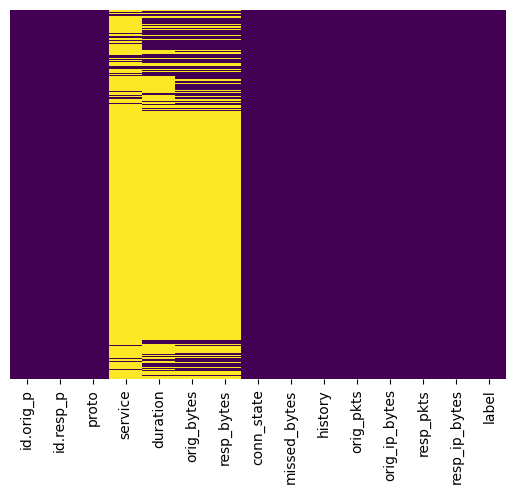

In [84]:
# Check null values using heatmap
sns.heatmap(data=data_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

- There are only 4 columns with a lot of missing values, one categorical ("service) and three numerical ("duration", "orig_bytes", "resp_bytes").
- One possible approach is to entirely discard these columns from the dataset. 
- Instead, we will try to impute their values to preserve any hidden information and check if we can obtain better prediction performance.

##### Impute missing values: categorical features

<Axes: xlabel='label', ylabel='count'>

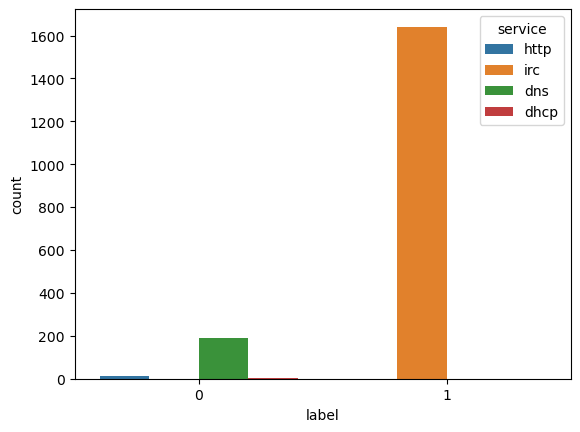

In [85]:
# Check the relationship between the "service" and the target attribute
sns.countplot(data=data_df, x="label", hue="service")

- Due to this visualization, almost all *Malicious* observations belong to a specific service type ("irc"), while the other 3 types represent *Benign* samples.
- Accordingly, although "service" feature has high number of missing values, it has a strong correlation with the target attribute.
- The decision here is to keep "service" attribute while trying to impute its missing values using another classifier. 

In [86]:
# Select specific columns to be used for the classification, here we initially select the numerical attributes with no missing values.
srv_training_columns = ["id.orig_p","id.resp_p","missed_bytes","orig_pkts","orig_ip_bytes","resp_pkts","resp_ip_bytes"] 

# Split the rows into two datasets containing rows with/without "service"
data_df_with_service = data_df[data_df["service"].notna()]
data_df_no_service = data_df[data_df["service"].isna()]

# Split the service dataset into dependent and independent features
srv_X = data_df_with_service[srv_training_columns]
srv_y = data_df_with_service["service"].values

# Split into train/test subsets
srv_X_train, srv_X_test, srv_y_train, srv_y_test = train_test_split(srv_X, srv_y, test_size=0.2, random_state=0)

# Create KNN estimator and fit it
srv_knn = KNeighborsClassifier(n_neighbors=3)
srv_knn.fit(srv_X_train, srv_y_train)

# Predict missing values
srv_y_pred = srv_knn.predict(srv_X_test)

# Check predictions accuracy
srv_accuracy_test = accuracy_score(srv_y_test, srv_y_pred)
print(f"Prediction accuracy for 'service' is: {srv_accuracy_test}")
print("Classification report:")
print(classification_report(srv_y_test, srv_y_pred))

Prediction accuracy for 'service' is: 1.0
Classification report:
              precision    recall  f1-score   support

         dns       1.00      1.00      1.00        41
        http       1.00      1.00      1.00         5
         irc       1.00      1.00      1.00       324

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



The classification model achieved an accuracy of 100%, which means all samples in the test subset were correctly predicted. Now we can use this model to predict missing "service" fields.

In [87]:
# Predict "service" for missing values
srv_predictions = srv_knn.predict(data_df_no_service[srv_training_columns])

# Update the original data set with predicted "service" values
data_df.loc[data_df["service"].isna(), "service"] = srv_predictions

##### Impute missing values: numerical features

In [88]:
# To preserve hidden correlations with other features in the dataset, we will use a KNN imputer to estimate the missing values based on relationships with other numerical features.
numerical_features = data_df.drop("label", axis=1).select_dtypes(include="number").columns
knn_imputer = KNNImputer()
data_df_after_imputing = knn_imputer.fit_transform(data_df[numerical_features])

In [89]:
# Update original data set to fill missing values with imputed ones
data_df[numerical_features] = data_df_after_imputing

In [90]:
# Confirm all missing values were successfully imputed
data_df.isnull().sum().sort_values(ascending=False)

id.orig_p        0
id.resp_p        0
proto            0
service          0
duration         0
orig_bytes       0
resp_bytes       0
conn_state       0
missed_bytes     0
history          0
orig_pkts        0
orig_ip_bytes    0
resp_pkts        0
resp_ip_bytes    0
label            0
dtype: int64

#### Scaling numerical attributes

As we aim to compare several classifiers, and since some of them rely on distance-based comparisons, we will scale the numerical features to have them represented in a unified distribution.

In [91]:
# Check statistics for numerical features
numerical_features = ["id.orig_p", "id.resp_p", "duration", "orig_bytes", "resp_bytes", "missed_bytes", "orig_pkts", "orig_ip_bytes",	"resp_pkts", "resp_ip_bytes"]
data_df[numerical_features].describe()

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,23145.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000
mean,56409.651847,2324.573558,3.019661,3.435934e+03,87.489721,2.127112,6.375157,3.664312e+03,0.611017,111.218967
std,17176.590987,5362.933817,0.362171,4.969529e+05,2582.581881,102.490787,178.548725,5.003762e+05,8.305898,2713.082822
min,0.000000,1.000000,0.553685,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,53622.000000,80.000000,3.093835,4.800000e+01,7.800000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,65279.000000,80.000000,3.093835,5.460000e+01,7.800000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,65279.000000,6667.000000,3.093835,5.460000e+01,7.800000,0.000000,1.000000,7.600000e+01,0.000000,0.000000
max,65279.000000,63798.000000,4.723553,7.554662e+07,164266.000000,5792.000000,18444.000000,7.606306e+07,1070.000000,168910.000000


Since most attributes have no normal distribution, it's more suitable to apply a normalization (between 0 and 1, using MinMaxScaler) instead of standardization.

In [92]:
# Initialize and apply MinMaxScaler scaler
min_max_scaler = MinMaxScaler()
data_df[numerical_features] = min_max_scaler.fit_transform(data_df[numerical_features])


In [93]:
# Check statistics for scaled features
data_df[numerical_features].describe()

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,23145.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000,23145.000000,2.314500e+04,23145.000000,23145.000000
mean,0.864132,0.036421,0.591380,4.548098e-05,0.000533,0.000367,0.000346,4.817466e-05,0.000571,0.000658
std,0.263126,0.084062,0.086854,6.578095e-03,0.015722,0.017695,0.009681,6.578439e-03,0.007763,0.016062
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.821428,0.001238,0.609168,6.353692e-07,0.000047,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,1.000000,0.001238,0.609168,7.227325e-07,0.000047,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,1.000000,0.104488,0.609168,7.227325e-07,0.000047,0.000000,0.000054,9.991710e-07,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000


#### Encoding categorical features

In [94]:
# Look for categorical features in the dataset
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23145 entries, 0 to 23144
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id.orig_p      23145 non-null  float64
 1   id.resp_p      23145 non-null  float64
 2   proto          23145 non-null  object 
 3   service        23145 non-null  object 
 4   duration       23145 non-null  float64
 5   orig_bytes     23145 non-null  float64
 6   resp_bytes     23145 non-null  float64
 7   conn_state     23145 non-null  object 
 8   missed_bytes   23145 non-null  float64
 9   history        23145 non-null  object 
 10  orig_pkts      23145 non-null  float64
 11  orig_ip_bytes  23145 non-null  float64
 12  resp_pkts      23145 non-null  float64
 13  resp_ip_bytes  23145 non-null  float64
 14  label          23145 non-null  int32  
dtypes: float64(10), int32(1), object(4)
memory usage: 2.7+ MB


- Since all categorical features don't imply an ordered relationship between their values, they can be encoded using One-Hot Encoding.
- We need first to check features with rare values and map them to "other", in order to avoid sparse columns with statistically negligible impact and higher computational effect.

##### Encoding categorical features: handle rare values

In [95]:
# Check the number of unique values in each feature
categorical_features = ["proto","service","conn_state","history"]
for c in categorical_features:
    print(f"Column ({c}) has ({data_df[c].nunique()}) distinct values.")

Column (proto) has (2) distinct values.
Column (service) has (4) distinct values.
Column (conn_state) has (6) distinct values.
Column (history) has (26) distinct values.


In [96]:
# Check values of "history" because it has too many unique values.
history_val_counts = data_df["history"].value_counts()
history_val_counts

C               14252
S                5417
ShAdDaf          1477
D                 978
Dd                836
ShAdDaft          102
ShAdfDr            48
CCCC                6
ShADadtcfF          3
ShADadttcfF         3
ShAdDatfr           2
CCC                 2
ShADadf             2
ShDadAf             2
ShAfdtDr            2
ShADacdtfF          2
ShADadtctfF         2
ShAdDatf            1
ShADadttfF          1
ShAdD               1
ShADadtctfFR        1
ShAdDfr             1
ShAD                1
DdAtaFf             1
ShADad              1
ShAdDa              1
Name: history, dtype: int64

In [97]:
# Map values to their frequencies
history_freq_map = data_df["history"].map(history_val_counts)

# Replace low frequent values in "history" with "Other" using the corresponding frequency map
data_df["history"] = data_df["history"].mask(history_freq_map < 10, "Other")

# Check "history" values after mapping
data_df["history"].value_counts()

C           14252
S            5417
ShAdDaf      1477
D             978
Dd            836
ShAdDaft      102
ShAdfDr        48
Other          35
Name: history, dtype: int64

##### Encoding categorical features: apply one-hot encoder

In [98]:
# Initialize the encoder with its default parameters
ohe = OneHotEncoder()

# Fit the encoder to categorical features in the dataset
encoded_features = ohe.fit_transform(data_df[categorical_features])

# Create a dataframe of encoded features
encoded_features_df = pd.DataFrame(encoded_features.toarray(), columns=ohe.get_feature_names_out())

# Check the results of encoding
encoded_features_df

,proto_tcp,proto_udp,service_dhcp,service_dns,service_http,service_irc,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_Other,history_S,history_ShAdDaf,history_ShAdDaft,history_ShAdfDr
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23140,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23141,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23142,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23143,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
# Merge encoded features with the dataset and drop original columns
data_df = pd.concat([data_df, encoded_features_df], axis=1).drop(categorical_features, axis=1)

### 4. STORING PROCESSED DATASET

#### Check the processed dataset

In [100]:
# Check the final version of the dataset
data_df.head()

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_tcp,proto_udp,service_dhcp,service_dns,service_http,service_irc,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_Other,history_S,history_ShAdDaf,history_ShAdDaft,history_ShAdfDr
0,0.628686,0.001238,0.620050,0.000000e+00,0.000000,0.0,0.000163,2.366458e-06,0.00000,0.000000,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.628686,0.001238,0.620022,3.097425e-07,0.000047,0.0,0.000054,7.888192e-07,0.00000,0.000000,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.628686,0.001238,0.620022,3.097425e-07,0.000047,0.0,0.000054,7.888192e-07,0.00000,0.000000,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.628686,0.001238,0.221583,1.972292e-06,0.780758,0.5,0.005097,7.263710e-05,0.08972,0.823184,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.628717,0.001238,0.621946,0.000000e+00,0.000000,0.0,0.000163,2.366458e-06,0.00000,0.000000,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [101]:
# Check not null values and attribute types
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23145 entries, 0 to 23144
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id.orig_p         23145 non-null  float64
 1   id.resp_p         23145 non-null  float64
 2   duration          23145 non-null  float64
 3   orig_bytes        23145 non-null  float64
 4   resp_bytes        23145 non-null  float64
 5   missed_bytes      23145 non-null  float64
 6   orig_pkts         23145 non-null  float64
 7   orig_ip_bytes     23145 non-null  float64
 8   resp_pkts         23145 non-null  float64
 9   resp_ip_bytes     23145 non-null  float64
 10  label             23145 non-null  int32  
 11  proto_tcp         23145 non-null  float64
 12  proto_udp         23145 non-null  float64
 13  service_dhcp      23145 non-null  float64
 14  service_dns       23145 non-null  float64
 15  service_http      23145 non-null  float64
 16  service_irc       23145 non-null  float6

#### Store processed dataset to a csv file

In [102]:
# Set file location and name
data_file_location = "..\\data\\processed\\"
data_file_name = "conn.log.labeled_processed"
data_file_ext = ".csv"

# Store processed dataset to a csv file
data_df.to_csv(data_file_location + data_file_name + data_file_ext)